## Step 1: Import Libraries & Config

In [1]:
import os
import copy
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from tqdm import tqdm

# ── Reproducibility ──────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Device: Apple Silicon MPS ─────────────────────────
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple MPS (GPU) 🚀')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using CUDA: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('Using CPU')

# ── Paths ──────────────────
BASE_DIR  = './data'
TRAIN_DIR = f'{BASE_DIR}/train'
TEST_DIR  = f'{BASE_DIR}/kaggle_test_final'

print(f'TRAIN_DIR exists: {os.path.exists(TRAIN_DIR)}')
print(f'TEST_DIR  exists: {os.path.exists(TEST_DIR)}')

# ── Hyperparameters ──────────────────────────────────────────
IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 15
LR         = 0.001
VAL_SPLIT  = 0.15
PATIENCE   = 5

print('Setup complete!')

Using Apple MPS (GPU) 🚀
TRAIN_DIR exists: True
TEST_DIR  exists: True
Setup complete!


## Step 2: Data Transforms (Train / Val / TTA)

In [2]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

# ── Train: Strong augmentation ────────────────────────────────
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))
])

# ── Val: No augmentation ─────────────────────────────────────
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# ── TTA: 5 versions ──────────────────────────────────────────
tta_transforms_list = [
    transforms.Compose([  # 1) Original
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    transforms.Compose([  # 2) Horizontal flip
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    transforms.Compose([  # 3) Center crop
        transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    transforms.Compose([  # 4) Rotation +10
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomRotation((10, 10)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    transforms.Compose([  # 5) Rotation -10
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomRotation((-10, -10)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
]

print('Transforms ready!')

Transforms ready!


## Step 3: Load Dataset & Train/Val Split (85/15)

In [3]:
# ── Load full training dataset ────────────────────────────────
full_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
classes      = full_dataset.classes
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
print(f'Classes found: {classes}')
print(f'class_to_idx : {full_dataset.class_to_idx}')
print(f'Total images : {len(full_dataset)}')

# ── Train / Val split 85/15 ───────────────────────────────────
val_size   = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size
train_subset, val_subset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

val_dataset_clean           = copy.deepcopy(val_subset.dataset)
val_dataset_clean.transform = val_transforms
val_dataset_final           = torch.utils.data.Subset(val_dataset_clean, val_subset.indices)

# ── DataLoaders ───────────────────────────────────────────────
# num_workers=0 for Apple MPS compatibility (avoid multiprocessing issues) --- IGNORE ---
train_loader = DataLoader(train_subset,      batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train: {train_size} | Val: {val_size}')

Classes found: ['chihuahua', 'muffin']
class_to_idx : {'chihuahua': 0, 'muffin': 1}
Total images : 4733
Train: 4024 | Val: 709


## Step 4: Test Dataset Class

In [4]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir    = test_dir
        self.transform   = transform
        self.image_files = sorted([
            f for f in os.listdir(test_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image    = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

print(f'Test images: {len(TestDataset(TEST_DIR))}')

Test images: 1138


## Step 5: Build Model — Custom CNN

In [5]:
class MuffinChihuahuaCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(MuffinChihuahuaCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 224 → 112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout2d(0.1),

            # Block 2: 112 → 56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout2d(0.15),

            # Block 3: 56 → 28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout2d(0.2),

            # Block 4: 28 → 14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout2d(0.2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model     = MuffinChihuahuaCNN(num_classes=2).to(device)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f'Model ready! Params: {trainable:,} / {total:,}')

Model ready! Params: 1,240,482 / 1,240,482


## Step 6: Phase 1 — Train All Layers (LR=0.001)

In [6]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

best_val_acc = 0.0
best_weights = copy.deepcopy(model.state_dict())
no_improve   = 0

print('===== Phase 1: Training (All Layers) =====')

for epoch in range(1, EPOCHS + 1):
    # ── Train ─────────────────────────────────────────────────
    model.train()
    running_loss, correct, total_n = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS} [Train]'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct  += (preds == labels).sum().item()
        total_n  += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_acc  = 100 * correct / total_n

    # ── Validate ──────────────────────────────────────────────
    model.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs       = model(images)
            loss          = criterion(outputs, labels)
            val_loss_sum += loss.item()
            _, preds      = torch.max(outputs, 1)
            val_correct  += (preds == labels).sum().item()
            val_total    += labels.size(0)
    val_loss = val_loss_sum / len(val_loader)
    val_acc  = 100 * val_correct / val_total

    scheduler.step()

    flag = ' ★ BEST' if val_acc > best_val_acc else ''
    print(f'Epoch [{epoch:02d}/{EPOCHS}] '
          f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%{flag}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())
        # บันทึก checkpoint ไว้ด้วย กันเครื่อง crash
        torch.save(best_weights, 'best_model.pth')
        no_improve   = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'Early stopping at epoch {epoch}')
            break

print(f'\nBest Val Accuracy (Phase 1): {best_val_acc:.2f}%')

===== Phase 1: Training (All Layers) =====


Epoch 1/15 [Train]: 100%|██████████| 126/126 [00:53<00:00,  2.36it/s]


Epoch [01/15] Train Loss: 0.5809 Acc: 73.51% | Val Loss: 0.4464 Acc: 86.60% ★ BEST


Epoch 2/15 [Train]: 100%|██████████| 126/126 [00:47<00:00,  2.66it/s]


Epoch [02/15] Train Loss: 0.4874 Acc: 80.54% | Val Loss: 0.3811 Acc: 87.73% ★ BEST


Epoch 3/15 [Train]: 100%|██████████| 126/126 [00:47<00:00,  2.64it/s]


Epoch [03/15] Train Loss: 0.4728 Acc: 82.70% | Val Loss: 0.4534 Acc: 83.07%


Epoch 4/15 [Train]: 100%|██████████| 126/126 [00:46<00:00,  2.70it/s]


Epoch [04/15] Train Loss: 0.4590 Acc: 84.62% | Val Loss: 0.3933 Acc: 87.45%


Epoch 5/15 [Train]: 100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


Epoch [05/15] Train Loss: 0.4548 Acc: 83.47% | Val Loss: 0.4079 Acc: 87.45%


Epoch 6/15 [Train]: 100%|██████████| 126/126 [00:45<00:00,  2.77it/s]


Epoch [06/15] Train Loss: 0.4458 Acc: 84.84% | Val Loss: 0.3788 Acc: 88.72% ★ BEST


Epoch 7/15 [Train]: 100%|██████████| 126/126 [01:11<00:00,  1.77it/s]


Epoch [07/15] Train Loss: 0.4304 Acc: 85.98% | Val Loss: 0.3849 Acc: 88.72%


Epoch 8/15 [Train]: 100%|██████████| 126/126 [00:46<00:00,  2.69it/s]


Epoch [08/15] Train Loss: 0.4248 Acc: 85.88% | Val Loss: 0.3538 Acc: 90.41% ★ BEST


Epoch 9/15 [Train]: 100%|██████████| 126/126 [00:47<00:00,  2.67it/s]


Epoch [09/15] Train Loss: 0.4282 Acc: 86.01% | Val Loss: 0.3538 Acc: 89.84%


Epoch 10/15 [Train]: 100%|██████████| 126/126 [00:46<00:00,  2.70it/s]


Epoch [10/15] Train Loss: 0.4173 Acc: 86.08% | Val Loss: 0.3481 Acc: 90.55% ★ BEST


Epoch 11/15 [Train]: 100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


Epoch [11/15] Train Loss: 0.4006 Acc: 88.00% | Val Loss: 0.3475 Acc: 90.13%


Epoch 12/15 [Train]: 100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


Epoch [12/15] Train Loss: 0.4048 Acc: 87.57% | Val Loss: 0.3629 Acc: 88.72%


Epoch 13/15 [Train]: 100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


Epoch [13/15] Train Loss: 0.3888 Acc: 88.10% | Val Loss: 0.3467 Acc: 89.84%


Epoch 14/15 [Train]: 100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


Epoch [14/15] Train Loss: 0.3915 Acc: 88.37% | Val Loss: 0.3488 Acc: 89.70%


Epoch 15/15 [Train]: 100%|██████████| 126/126 [00:46<00:00,  2.72it/s]


Epoch [15/15] Train Loss: 0.3838 Acc: 89.07% | Val Loss: 0.3409 Acc: 90.69% ★ BEST

Best Val Accuracy (Phase 1): 90.69%


## Step 7: Phase 2 — Fine-tune All Layers (LR=0.0001)

In [7]:
model.load_state_dict(best_weights)

for param in model.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Phase 2 Trainable params: {trainable:,}')

optimizer2 = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
EPOCHS2    = 10
scheduler2 = optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=EPOCHS2, eta_min=1e-6)
no_improve = 0

print('\n===== Phase 2: Fine-tuning (Lower LR) =====')

for epoch in range(1, EPOCHS2 + 1):
    # ── Train ─────────────────────────────────────────────────
    model.train()
    running_loss, correct, total_n = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS2} [Fine-tune]'):
        images, labels = images.to(device), labels.to(device)
        optimizer2.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct  += (preds == labels).sum().item()
        total_n  += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_acc  = 100 * correct / total_n

    # ── Validate ──────────────────────────────────────────────
    model.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs       = model(images)
            loss          = criterion(outputs, labels)
            val_loss_sum += loss.item()
            _, preds      = torch.max(outputs, 1)
            val_correct  += (preds == labels).sum().item()
            val_total    += labels.size(0)
    val_loss = val_loss_sum / len(val_loader)
    val_acc  = 100 * val_correct / val_total

    scheduler2.step()

    flag = ' ★ BEST' if val_acc > best_val_acc else ''
    print(f'Epoch [{epoch:02d}/{EPOCHS2}] '
          f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%{flag}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())
        torch.save(best_weights, 'best_model.pth')
        no_improve   = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'Early stopping at epoch {epoch}')
            break

model.load_state_dict(best_weights)
print(f'\nFinal Best Val Accuracy: {best_val_acc:.2f}%')

Phase 2 Trainable params: 1,240,482

===== Phase 2: Fine-tuning (Lower LR) =====


Epoch 1/10 [Fine-tune]: 100%|██████████| 126/126 [00:46<00:00,  2.69it/s]


Epoch [01/10] Train Loss: 0.3942 Acc: 88.07% | Val Loss: 0.3559 Acc: 89.84%


Epoch 2/10 [Fine-tune]: 100%|██████████| 126/126 [00:46<00:00,  2.69it/s]


Epoch [02/10] Train Loss: 0.3846 Acc: 88.89% | Val Loss: 0.3325 Acc: 91.96% ★ BEST


Epoch 3/10 [Fine-tune]: 100%|██████████| 126/126 [00:46<00:00,  2.71it/s]


Epoch [03/10] Train Loss: 0.3885 Acc: 88.54% | Val Loss: 0.3345 Acc: 90.97%


Epoch 4/10 [Fine-tune]: 100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


Epoch [04/10] Train Loss: 0.3866 Acc: 88.62% | Val Loss: 0.3456 Acc: 90.13%


Epoch 5/10 [Fine-tune]: 100%|██████████| 126/126 [00:46<00:00,  2.73it/s]


Epoch [05/10] Train Loss: 0.3865 Acc: 88.87% | Val Loss: 0.3277 Acc: 91.96%


Epoch 6/10 [Fine-tune]: 100%|██████████| 126/126 [00:46<00:00,  2.74it/s]


Epoch [06/10] Train Loss: 0.3828 Acc: 88.44% | Val Loss: 0.3530 Acc: 89.84%


Epoch 7/10 [Fine-tune]: 100%|██████████| 126/126 [00:46<00:00,  2.74it/s]


Epoch [07/10] Train Loss: 0.3840 Acc: 88.99% | Val Loss: 0.3450 Acc: 90.27%
Early stopping at epoch 7

Final Best Val Accuracy: 91.96%


## Step 8: TTA Inference on Test Set (5 passes)

In [8]:
print('Starting TTA Inference...')
model.eval()
softmax = nn.Softmax(dim=1)

all_probs     = None
all_filenames = None

for t_idx, tta_transform in enumerate(tta_transforms_list):
    print(f'  TTA pass {t_idx + 1}/{len(tta_transforms_list)}...')
    test_dataset = TestDataset(test_dir=TEST_DIR, transform=tta_transform)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0)
    pass_probs = []
    pass_files = []

    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc=f'TTA {t_idx+1}', leave=False):
            images  = images.to(device)
            outputs = model(images)
            probs   = softmax(outputs).cpu().numpy()
            pass_probs.append(probs)
            if t_idx == 0:
                pass_files.extend(filenames)

    pass_probs = np.concatenate(pass_probs, axis=0)
    if all_probs is None:
        all_probs     = pass_probs
        all_filenames = pass_files
    else:
        all_probs += pass_probs

all_probs   /= len(tta_transforms_list)
pred_indices = np.argmax(all_probs, axis=1)
predictions  = [idx_to_class[i] for i in pred_indices]

print(f'Done! Total predictions: {len(predictions)}')

Starting TTA Inference...
  TTA pass 1/5...


  TTA pass 2/5...


  TTA pass 3/5...


  TTA pass 4/5...


  TTA pass 5/5...


Done! Total predictions: 1138


## Step 9: Save submission.csv

In [9]:
submission_df = pd.DataFrame({
    'ID'     : all_filenames,
    'Predict': predictions
})

submission_df.to_csv('submission.csv', index=False)
print('submission.csv saved!')
print(submission_df.head(10))
print(f'\nPrediction distribution:')
print(submission_df['Predict'].value_counts())

submission.csv saved!
               ID    Predict
0     img_0_0.jpg     muffin
1    img_0_10.jpg     muffin
2  img_0_1000.jpg     muffin
3  img_0_1037.jpg     muffin
4   img_0_105.jpg     muffin
5  img_0_1050.jpg     muffin
6  img_0_1051.jpg     muffin
7  img_0_1061.jpg     muffin
8  img_0_1063.jpg     muffin
9  img_0_1071.jpg  chihuahua

Prediction distribution:
Predict
chihuahua    643
muffin       495
Name: count, dtype: int64


## Step 10: Confusion Matrix & Classification Report

--- Classification Report (Validation Set) ---
              precision    recall  f1-score   support

   chihuahua       0.93      0.91      0.92       364
      muffin       0.91      0.92      0.92       345

    accuracy                           0.92       709
   macro avg       0.92      0.92      0.92       709
weighted avg       0.92      0.92      0.92       709



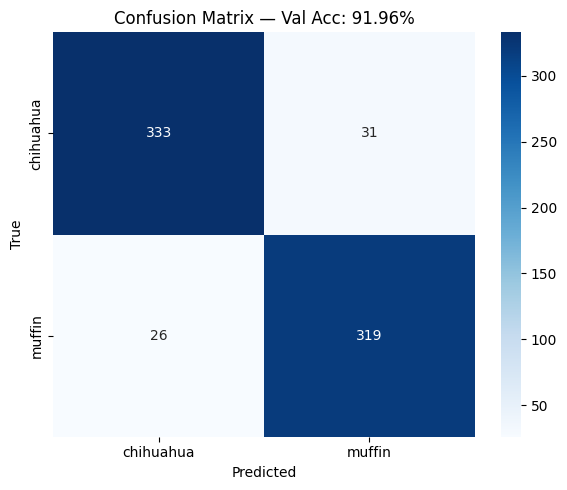

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred_all = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images   = images.to(device)
        outputs  = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred_all.extend(preds.cpu().numpy())

print('--- Classification Report (Validation Set) ---')
print(classification_report(y_true, y_pred_all, target_names=classes))

cm = confusion_matrix(y_true, y_pred_all)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix — Val Acc: {best_val_acc:.2f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()